In [23]:
from dotenv import load_dotenv

load_dotenv()

True

# Test Adam Chatbot

## Archi langgraph, Idea 1

In [2]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int

def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input

def tool_calling_router(input: InputState):
    if input["string_value"] == "question":
        return "simple_question_on_topic"
    elif input["string_value"] == "generate_MCQ":
        return "generate_MCQ_on_topic"
    elif input["string_value"] == "generate_QA":
        return "generate_QA_on_topic"
    elif input["string_value"] == "question_on_chatbot":
        return "question_on_chatbot"
    elif input["string_value"] == "request_not_on_topic":
        return "request_not_on_topic"
    else:
        return "__end__"

def answer_pedagogicaly(input: InputState):
    return 

def generate_MCQ_on_topic(input: InputState):
    return

def generate_QA_on_topic(input: InputState):
    return

def answer_question_on_chatbot(input: InputState):
    return

def request_not_on_topic(input: InputState):
    return

def rag_for_simple_question(input: InputState):
    return

def rag_for_mcq(input: InputState):
    return

def rag_for_qa(input: InputState):
    return

def generate_comments(input: InputState):
    return



In [3]:
graphID1 = StateGraph(InputState)

graphID1.add_node("tool_calling_router", tool_calling_router)

graphID1.add_node("RAG_for_simple_question", rag_for_simple_question)
graphID1.add_node("answer_pedagogicaly", answer_pedagogicaly)

graphID1.add_node("RAG_for_MCQ", rag_for_mcq)
graphID1.add_node("generate_MCQ_on_topic", generate_MCQ_on_topic)
graphID1.add_node("generate_comments_on_MCQ", generate_comments)

graphID1.add_node("RAG_for_Q&A", rag_for_qa)
graphID1.add_node("generate_Q&A_on_topic", generate_QA_on_topic)
graphID1.add_node("generate_comments_on_Q&A", generate_comments)

graphID1.add_node("question_on_chatbot", answer_question_on_chatbot)

graphID1.add_node("request_not_on_topic", request_not_on_topic)


graphID1.add_edge(START, "tool_calling_router")
graphID1.add_conditional_edges(
    "tool_calling_router", tool_calling_router, {"RAG_for_simple_question": "RAG_for_simple_question", 
                                                 "RAG_for_MCQ": "RAG_for_MCQ", 
                                                 "RAG_for_Q&A": "RAG_for_Q&A", 
                                                 "question_on_chatbot": "question_on_chatbot", 
                                                 "request_not_on_topic": "request_not_on_topic"})
graphID1.add_edge("RAG_for_simple_question", "answer_pedagogicaly")
graphID1.add_edge("answer_pedagogicaly", END)
graphID1.add_edge("RAG_for_MCQ", "generate_MCQ_on_topic")
graphID1.add_edge("generate_MCQ_on_topic", "generate_comments_on_MCQ")
graphID1.add_edge("generate_comments_on_MCQ", END)
graphID1.add_edge("RAG_for_Q&A", "generate_Q&A_on_topic")
graphID1.add_edge("generate_Q&A_on_topic", "generate_comments_on_Q&A")
graphID1.add_edge("generate_comments_on_Q&A", END)
graphID1.add_edge("question_on_chatbot", END)
graphID1.add_edge("request_not_on_topic", END)

graphID1.set_entry_point("tool_calling_router")

runnable = graphID1.compile()

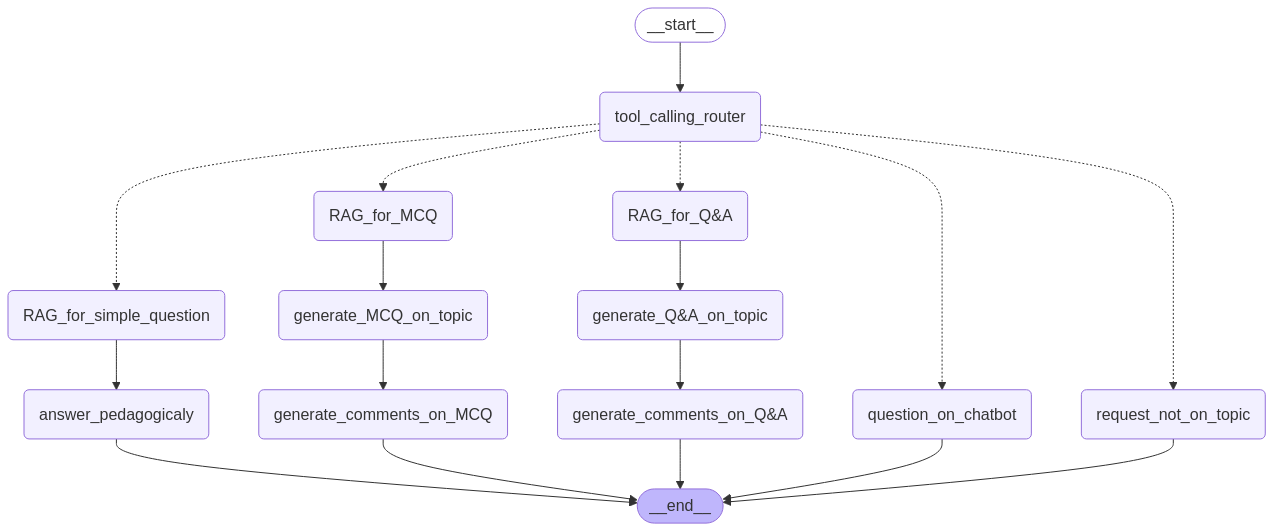

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Change documents from .pdf with images to .txt without images and explanation instead

In [5]:
# !pip install langchain-anthropic

In [24]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END


class StorageAgentState(TypedDict):
    base_path_txt: str
    base_path_pdf: str
    missing_txt: List[Document]
    missing_pdf: List[str]
    rephrased_documents: List[str]

In [25]:
import os

def init(state: StorageAgentState):
    print("Entering init")
    state["base_path_txt"] = "data_txt"
    state["base_path_pdf"] = "data_pdf"
    state["missing_txt"] = []
    state["missing_pdf"] = []
    state["rephrased_documents"] = []
    return state

def find_missing_txt_files(state: StorageAgentState):
    """
    Identifies PDF files in pdf_dir that don't have corresponding TXT files in txt_dir.
    
    Args:
        pdf_dir (str): Directory containing PDF files (default: "data_pdf")
        txt_dir (str): Directory containing TXT files (default: "data_txt")
    
    Returns:
        list: List of missing TXT filenames (without path, but with .txt extension)
    """
    print("Entering find_missing_txt_files")
    pdf_dir = state["base_path_pdf"]
    txt_dir = state["base_path_txt"]

    # Create directories if they don't exist
    os.makedirs(pdf_dir, exist_ok=True)
    os.makedirs(txt_dir, exist_ok=True)
    
    # Get list of PDF files
    pdf_files = []
    for filename in os.listdir(pdf_dir):
        if filename.lower().endswith('.pdf'):
            pdf_files.append(filename)
    
    # Get list of TXT files
    txt_files = []
    for filename in os.listdir(txt_dir):
        if filename.lower().endswith('.txt'):
            txt_files.append(filename)
    
    # Convert PDF filenames to expected TXT filenames
    expected_txt_files = [os.path.splitext(pdf)[0] + '.txt' for pdf in pdf_files]
    
    # Find missing TXT files
    counter = 0
    for i, txt in enumerate(expected_txt_files):
        if txt not in txt_files:
            i -= counter
            state["missing_txt"].append({"page_content": "", "metadata": {"path": "", "topic": "Deep Learning", "doc_type": "cours", "doc_subject": ""}})
            state["missing_txt"][i]["metadata"]["path"] = os.path.join(txt_dir, txt)
            state["missing_txt"][i]["metadata"]["doc_subject"] = os.path.splitext(txt)[0]
            state["missing_pdf"].append(os.path.join(pdf_dir,os.path.splitext(txt)[0] + '.pdf'))
        else:
            counter += 1
    print(f"Found {len(pdf_files)} PDF files in '{pdf_dir}'")
    print(f"Found {len(txt_files)} TXT files in '{txt_dir}'")
    print(f"Missing {len(state["missing_txt"])} TXT files")
    print("Missing TXT files:", state["missing_txt"])
    print("PDFs needing processing:", state["missing_pdf"])
    
    return state

def get_missing_pdf_paths(state: StorageAgentState):
    """
    Returns the full paths of PDF files that don't have corresponding TXT files.
    
    Args:
        pdf_dir (str): Directory containing PDF files (default: "data_pdf")
        txt_dir (str): Directory containing TXT files (default: "data_txt")
    
    Returns:
        list: List of full paths to PDF files that need processing
    """
    print("Entering get_missing_pdf_paths")
    pdf_dir = state["base_path_pdf"]

    missing_txt_files = state["missing_txt"]

    # Convert missing TXT filenames back to PDF filenames
    missing_pdf_files = [os.path.splitext(txt)[0] + '.pdf' for txt in missing_txt_files]

    # Create full paths
    state["missing_pdf"] = [os.path.join(pdf_dir, pdf) for pdf in missing_pdf_files]
    # for i, pdf in enumerate(missing_pdf_files):
    #     state["missing_pdf"].append({"page_content": "", "metadata": {"path": "", "topic": "Deep Learning", "doc_type": "cours", "doc_subject": ""}})
    #     state["missing_pdf"][i]["metadata"]["path"] = os.path.join(pdf_dir, pdf)
    print("PDFs needing processing:", state["missing_pdf"])

    return state

In [222]:
# !pip install langchain_google_genai

In [31]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.messages import HumanMessage
import base64
import os
from dotenv import load_dotenv
import fitz  # PyMuPDF
from PIL import Image
import io
import mimetypes


# Load environment variables
load_dotenv()

# Function to convert PDF to images and encode them
# def pdf_to_base64_images(pdf_path):
#     images = []
#     pdf_document = fitz.open(pdf_path)
    
#     for page_number in range(len(pdf_document)):
#         page = pdf_document.load_page(page_number)
#         pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # 2x zoom for better resolution
        
#         # Convert to PIL Image
#         img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        
#         # Convert to base64
#         buffered = io.BytesIO()
#         img.save(buffered, format="PNG")
#         img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
#         images.append(img_base64)
    
#     return images

def pdf_to_base64_images(pdf_path):  # Limit pages to avoid context limits
    images = []
    pdf_document = fitz.open(pdf_path)
        
    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # Higher resolution
        
        # Convert to PIL Image
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        
        # Convert to base64
        buffered = io.BytesIO()
        img.save(buffered, format="PNG", quality=85)  # JPEG for better compatibility
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
        images.append(img_base64)
    
    return images

def create_txt_content(state: StorageAgentState):
    for i in range(len(state["missing_pdf"])):
        # Path to your PDF
        print(f"Processing: {state["missing_txt"][i]["metadata"]['doc_subject']}")
        pdf_path = state["missing_pdf"][i]
        base64_images = pdf_to_base64_images(pdf_path)


        # Create content list with all PDF pages as images
        content= [
            {"type": "text", "text": f"Tu es expert en {state["missing_txt"][i]["metadata"]['topic']}.\n"
            f"Voici un {state["missing_txt"][i]["metadata"]['doc_type']} sur {state["missing_txt"][i]["metadata"]['doc_subject']}.\n"
            "Il y a dans ce document des images explicatives et des formules mathématiques.\n"
            "Ton but est de faire un fichier texte qui redit exactement tout ce qui est expliqué dans ce "
            "document en incluant les formules mathématiques et les explications que les images peuvent apporter.\n"
            }
        ]
        

        # Add each page as an image
        for img_base64 in base64_images:
            content.append({
                "type": "image",
                "source": {
                    "type": "base64",
                    "media_type": "image/png",
                    "data": img_base64
                }

                # "type": "image_url",
                # "image_url": {
                #     "url": f"data:application/pdf;base64,{base64_pdf}"
                # }

                # "type": "image_url",
                # "image_url": {
                #     "url": f"data:image/jpeg;base64,{img_base64}"
                # }
            })


        # Initialize Claude through LangChain
        llm = ChatAnthropic(
            model="claude-3-7-sonnet-20250219",
            max_tokens=9092,
        )
        # llm = ChatOpenAI(
        #     model="gpt-4o-mini",
        # )
        # llm = ChatGoogleGenerativeAI(
        #     model="models/gemini-2.0-flash-exp",
        # )
        # Create a message with the PDF pages as images
        message = HumanMessage(content=content)

        # Get response
        response = llm.invoke([message])
        print(response.content)
        state["missing_txt"][i]["page_content"] = response.content
    return state

In [28]:
def create_txt_files(state: StorageAgentState):
    print("Entering create_txt_files")
    for i in range(len(state["missing_pdf"])):
        with open(state["missing_txt"][i]["metadata"]["path"], "w") as f:
            f.write(state["missing_txt"][i]["page_content"])

    return state

In [32]:
from langgraph.graph import StateGraph, END

# Workflow
# storage_workflow = StateGraph(StorageAgentState)
storage_workflow = StateGraph(AgentState)
storage_workflow.add_node("init", init)
storage_workflow.add_node("find_missing_txt_files", find_missing_txt_files)
# storage_workflow.add_node("get_missing_pdf_paths", get_missing_pdf_paths)
storage_workflow.add_node("create_txt_content", create_txt_content)
storage_workflow.add_node("create_txt_files", create_txt_files)
# storage_workflow.add_node("generate_answer", generate_answer)
# storage_workflow.add_node("refine_question", refine_question)
# storage_workflow.add_node("cannot_answer", cannot_answer)

storage_workflow.add_edge("init", "find_missing_txt_files")
# storage_workflow.add_conditional_edges(
#     "question_classifier",
#     on_topic_router,
#     {
#         "retrieve": "retrieve",
#         "off_topic_response": "off_topic_response",
#     },
# )
storage_workflow.add_edge("find_missing_txt_files", "create_txt_content")
# storage_workflow.add_edge("find_missing_txt_files", "get_missing_pdf_paths")
# storage_workflow.add_conditional_edges(
#     "retrieval_grader",
#     proceed_router,
#     {
#         "generate_answer": "generate_answer",
#         "refine_question": "refine_question",
#         "cannot_answer": "cannot_answer",
#     },
# )
# storage_workflow.add_edge("refine_question", "retrieve")
storage_workflow.add_edge("create_txt_content", "create_txt_files")
storage_workflow.add_edge("create_txt_files", END)
# storage_workflow.add_edge("off_topic_response", END)
storage_workflow.set_entry_point("init")
storage_graph = storage_workflow.compile()

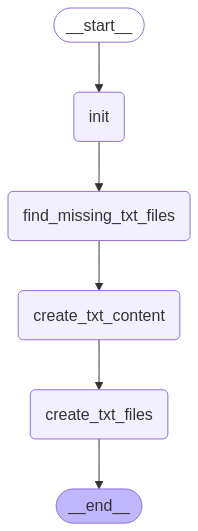

In [30]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        storage_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [34]:
off_topic_content_rag = "How is the weather?"
input_data = {"question": HumanMessage(content=off_topic_content_rag)}
storage_graph.invoke(input=input_data, config={"configurable": {"thread_id": 9}})

Entering init
Entering find_missing_txt_files
Found 8 PDF files in 'data_pdf'
Found 7 TXT files in 'data_txt'
Missing 1 TXT files
Missing TXT files: [{'page_content': '', 'metadata': {'path': 'data_txt/Leçon #5 - RNN - 2025.txt', 'topic': 'Deep Learning', 'doc_type': 'cours', 'doc_subject': 'Leçon #5 - RNN - 2025'}}]
PDFs needing processing: ['data_pdf/Leçon #5 - RNN - 2025.pdf']
Processing: Leçon #5 - RNN - 2025
# RÉSEAU DE NEURONES RÉCURRENTS (RNN) - LEÇON #5

## PRÉSENTATION

Par Kévin Bouchard Ph.D.
Professeur titulaire en intelligence artificielle et apprentissage automatique
Laboratoire d'Intelligence Ambiante pour la reconnaissance d'activités (LIARA)
Directeur de l'Espace innovation en technologies numériques Hydro-Québec
Président du Regroupement québécois des maladies orphelines (RQMO)
Université du Québec à Chicoutimi
www.Kevin-Bouchard.ca          Kevin_Bouchard@uqac.ca

## CONTENU DE LA LEÇON #5

Vous apprendrez:
- L'intérêt d'inventer des opérations particulières dans les

{'question': HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={})}

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def pdf_to_text(text,topic, doc_type, doc_subject):
    # Anthropic
    claude37 = "claude-3-7-sonnet-20250219"

    # OpenAI
    gpt4o = "gpt-4o"

    # model = ChatOpenAI(model=gpt4o)
    model = ChatAnthropic(model=claude37)

    prompt = ChatPromptTemplate.from_template(
    "Tu es expert en {topic}.\n"
    "Voici un {doc_type} sur {doc_subject}.\n"
    "Il y a dans ce document des images explicatives et des formules mathématiques.\n"
    "Ton but est de faire un fichier texte qui redit exactement tout ce qui est expliqué dans ce "
    "document en incluant les formules mathématiques et les explications que les images peuvent apporter.\n\n"
    "{text}"
    )

    output_parser = StrOutputParser()

    chain = (
        {"topic": RunnablePassthrough()}
        | {"doc_type": RunnablePassthrough()}
        | {"doc_subject": RunnablePassthrough()}
        | {"text": RunnablePassthrough()}
        | prompt
        | model
        | output_parser
    )

    response = chain.invoke({"text": text})
    return response

In [32]:
import base64

# Function to encode PDF as base64
def encode_pdf_to_base64(pdf_path):
    with open(pdf_path, "rb") as pdf_file:
        return base64.b64encode(pdf_file.read()).decode('utf-8')

# Path to your PDF
pdf_path = "data_pdf/Leçon #1 - Introduction.pdf"
base64_pdf = encode_pdf_to_base64(pdf_path)

In [251]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm.invoke("Sing a ballad of LangChain.")

AIMessage(content='(Verse 1)\nThe code was dark, the data deep, a labyrinth of lore,\nNo human mind could hope to keep the knowledge at its core.\nThe models strained, the queries choked, the answers slow and thin,\nA better way, the people hoped, to let the wisdom win.\n\n(Chorus)\nThen LangChain came, a shining star, to weave a magic thread,\nConnecting chains both near and far, the words the models said.\nFrom documents vast, to APIs bright, a knowledge river flowed,\nLangChain forged the path of light, where understanding growed.\n\n(Verse 2)\nWith chains of prompt and memory, and agents keen and bold,\nIt navigated complexity, a story to be told.\nIt parsed the texts, it learned the facts, it reasoned and it planned,\nAnd offered insights, free from cracks, a helper close at hand.\n\n(Chorus)\nFor LangChain came, a shining star, to weave a magic thread,\nConnecting chains both near and far, the words the models said.\nFrom documents vast, to APIs bright, a knowledge river flowed,\

In [37]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
import base64
import os
from dotenv import load_dotenv
import mimetypes
import fitz  # PyMuPDF for PDF to image conversion
from PIL import Image
import io

# Load environment variables
load_dotenv()

# Function to convert PDF to images and encode them
def pdf_to_base64_images(pdf_path):  # Limit pages to avoid context limits
    images = []
    pdf_document = fitz.open(pdf_path)
    
    # Limit number of pages if PDF is too long
    num_pages = len(pdf_document)
    
    for page_number in range(num_pages):
        page = pdf_document.load_page(page_number)
        pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # Higher resolution
        
        # Convert to PIL Image
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        
        # Convert to base64
        buffered = io.BytesIO()
        img.save(buffered, format="JPEG", quality=85)  # JPEG for better compatibility
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
        images.append(img_base64)
    
    return images

# Path to your PDF
pdf_path = "data_pdf/Leçon #2 - Neurone artificiel.pdf"
base64_images = pdf_to_base64_images(pdf_path)

# Initialize Gemini through LangChain
llm = ChatGoogleGenerativeAI(
    model="models/gemini-2.0-flash",
    max_tokens=5120

)

# Build content with all PDF pages as images
content = []
content.append({
    "type": "text",
    "text": "Tu es expert en deep learning.\n"
            "Voici un cours sur l'introduction au deep learning.\n"
            "Il y a dans ce document des images explicatives et des formules mathématiques.\n"
            "Ton but est de faire un fichier texte qui redit exactement tout ce qui est expliqué dans ce "
            "document en incluant les formules mathématiques et les explications que les images peuvent apporter.\n"
})

# Add each page as an image
for img_base64 in base64_images:
    content.append({
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{img_base64}"
        }
    })

# Create a message with the PDF pages as images
message = HumanMessage(content=content)

# Get response
response = llm.invoke([message])
print(response.content)

Bien sûr, voici le contenu textuel du cours sur les neurones artificiels, en incluant les formules et les explications des images.

**NEURONES ARTIFICIELS**

Par Kévin Bouchard Ph.D.
Professeur titulaire en intelligence artificielle et apprentissage automatique
Laboratoire d'Intelligence Ambiante pour la reconnaissance d'activités (LIARA)
Directeur de l'Espace innovation en technologies numériques Hydro-Québec
Président du Regroupement québécois des maladies orphelines (RQMO)
Université du Québec à Chicoutimi
www.kevin-bouchard.ca  Kevin_Bouchard@uqac.ca

**CONTENU DE LA LEÇON #2**

Vous apprendrez:
* Comment fonctionne un seul neurone artificiel (ou réviserez)
* Comment on entraîne un Adaline et le passage vers l'optimisation
* Nous essaierons également de définir l'apprentissage profond comme un sous-domaine de l'intelligence artificielle

Contenu spécifique:
* Retour sur le Perceptron
* Exercices
* Adaline et le gradient
* Retour sur Logistic Regression
* Exemples de code

**UN BREF

In [19]:
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage
import base64
import os
from dotenv import load_dotenv
import fitz  # PyMuPDF
from PIL import Image
import io

# Load environment variables
load_dotenv()

# Function to convert PDF to images and encode them
def pdf_to_base64_images(pdf_path):
    images = []
    pdf_document = fitz.open(pdf_path)
    
    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # 2x zoom for better resolution
        
        # Convert to PIL Image
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        
        # Convert to base64
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
        images.append(img_base64)
    
    return images

# Path to your PDF
pdf_path = "data_pdf/Leçon #8 - Graph neural network.pdf"
base64_images = pdf_to_base64_images(pdf_path)

# Create content list with all PDF pages as images
content = [{"type": "text", "text": "Tu es expert en deep learning.\n"
    "Voici un cours sur: Leçon #8 - Graph neural network.\n"
    "Il y a dans ce document des images explicatives et des formules mathématiques.\n"
    "Ton but est de faire un fichier texte qui redit exactement tout ce qui est expliqué dans ce "
    "document en incluant les formules mathématiques et les explications que les images peuvent apporter.\n"}]

# Add each page as an image
for img_base64 in base64_images:
    content.append({
        "type": "image",
        "source": {
            "type": "base64",
            "media_type": "image/png",
            "data": img_base64
        }
    })

# Initialize Claude through LangChain
llm = ChatAnthropic(
    model="claude-3-7-sonnet-20250219",
    max_tokens=9092
)

# Create a message with the PDF pages as images
message = HumanMessage(content=content)

# Get response
response = llm.invoke([message])
print(response.content)

# GRAPH NEURAL NETWORKS

Par Kévin Bouchard Ph.D.
Professeur titulaire en intelligence artificielle et apprentissage automatique
Laboratoire d'Intelligence Ambiante pour la reconnaissance d'activités (LIARA)
Directeur de l'Espace innovation en technologies numériques Hydro-Québec
Président du Regroupement québécois des maladies orphelines (RQMO)
Université du Québec à Chicoutimi
www.Kevin-Bouchard.ca        Kevin_Bouchard@uqac.ca

## TABLE DES MATIÈRES

1. Motivation
2. Types de graphes
3. Applications dans les graphes
4. Node embeddings
5. GNN

## HISTORIQUE DES GNN

- Les graphes attirent l'intérêt des chercheurs en mathématique et en informatique depuis très longtemps
- La première application concrète des réseaux de neurones aux graphes date de 1997 - A. Sperduti and A. Starita
- Cependant, la première référence connu au GNN vient de Gori et al. (2005), puis de Scarselli et al. (2009) et enfin de Gallicchio et al. (2010)
  - Ces GNN tombaient dans la catégorie des réseaux récurrent

In [ ]:
# from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, UnstructuredMarkdownLoader
# from langchain.schema import Document

# def create_txt():
#     loader = DirectoryLoader("./data_pdf", glob="**/*.pdf", loader_cls=PyPDFLoader)
#     # loader = DirectoryLoader("./data_md", glob="**/*.md", loader_cls=UnstructuredMarkdownLoader)
#     # loader = DirectoryLoader("./data_txt", glob="**/*.txt")
#     docs = loader.load()
    

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
import base64
import os
from dotenv import load_dotenv
import mimetypes
import fitz  # PyMuPDF for PDF to image conversion
from PIL import Image
import io

# Load environment variables
load_dotenv()

# Function to convert PDF to images and encode them
def pdf_to_base64_images(pdf_path):  # Limit pages to avoid context limits
    images = []
    pdf_document = fitz.open(pdf_path)
    
    # Limit number of pages if PDF is too long
    num_pages = len(pdf_document)
    
    for page_number in range(num_pages):
        page = pdf_document.load_page(page_number)
        pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # Higher resolution
        
        # Convert to PIL Image
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        
        # Convert to base64
        buffered = io.BytesIO()
        img.save(buffered, format="JPEG", quality=85)  # JPEG for better compatibility
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
        images.append(img_base64)
    
    return images

# Path to your PDF
pdf_path = "data_pdf/Leçon #8 - Graph neural network.pdf"
base64_images = pdf_to_base64_images(pdf_path)

# Initialize Gemini through LangChain
llm = ChatGoogleGenerativeAI(
    model="models/gemini-2.0-flash",
    max_tokens=5120

)

# Build content with all PDF pages as images
content = []
content.append({
    "type": "text",
    "text": "Tu es expert en deep learning.\n"
            "Voici un cours sur: Leçon #8 - Graph neural network.\n"
            "Il y a dans ce document des images explicatives et des formules mathématiques.\n"
            "Ton but est de faire un fichier texte qui redit exactement tout ce qui est expliqué dans ce "
            "document en incluant les formules mathématiques et les explications que les images peuvent apporter.\n"
})

# Add each page as an image
for img_base64 in base64_images:
    content.append({
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{img_base64}"
        }
    })

# Create a message with the PDF pages as images
message = HumanMessage(content=content)

# Get response
response = llm.invoke([message])
print(response.content)

Bien sûr, voici le contenu textuel du cours sur les neurones artificiels, en incluant les formules et les explications des images.

**NEURONES ARTIFICIELS**

Par Kévin Bouchard Ph.D.
Professeur titulaire en intelligence artificielle et apprentissage automatique
Laboratoire d'Intelligence Ambiante pour la reconnaissance d'activités (LIARA)
Directeur de l'Espace innovation en technologies numériques Hydro-Québec
Président du Regroupement québécois des maladies orphelines (RQMO)
Université du Québec à Chicoutimi
www.kevin-bouchard.ca  Kevin_Bouchard@uqac.ca

**CONTENU DE LA LEÇON #2**

Vous apprendrez:
* Comment fonctionne un seul neurone artificiel (ou réviserez)
* Comment on entraîne un Adaline et le passage vers l'optimisation
* Nous essaierons également de définir l'apprentissage profond comme un sous-domaine de l'intelligence artificielle

Contenu spécifique:
* Retour sur le Perceptron
* Exercices
* Adaline et le gradient
* Retour sur Logistic Regression
* Exemples de code

**UN BREF

## Documents vectorization

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import re
from langchain_openai import ChatOpenAI
from typing import Any, List
from langchain_text_splitters import TextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

class GPTSplitter(TextSplitter):
    def __init__(self, model_name: str = "gpt-4o-mini", **kwargs: Any) -> None:
        super().__init__(**kwargs)
        self.model = ChatOpenAI(model=model_name)

        self.prompt = ChatPromptTemplate.from_template(
            "You are an expert in identifying semantic meaning of text. "
            "You wrap each chunk in <<<>>>.\n\n"
            "Example:\n"
            "Text: \"The curious cat perched on the windowsill, its eyes wide as it watched the fluttering birds outside. "
            "With a swift leap, it was on the ground, stealthily making its way towards the door. "
            "Suddenly, a noise startled it, causing the cat to freeze in place.\"\n"
            "Wrapped:\n"
            "<<<The curious cat perched on the windowsill, its eyes wide as it watched the fluttering birds outside.>>>\n"
            "<<<With a swift leap, it was on the ground, stealthily making its way towards the door.>>>\n"
            "<<<Suddenly, a noise startled it, causing the cat to freeze in place.>>>\n\n"
            "Now, process the following text:\n\n"
            "{text}"
        )
        self.output_parser = StrOutputParser()
        self.chain = (
            {"text": RunnablePassthrough()}
            | self.prompt
            | self.model
            | self.output_parser
        )

    def split_text(self, text: str) -> List[str]:
        response = self.chain.invoke({"text": text})
        # Use regex to split properly by <<< and >>> markers
        chunks = re.findall(r'<<<(.*?)>>>', response, re.DOTALL)
        return [chunk.strip() for chunk in chunks]

In [3]:
# !pip install "unstructured[md]" nltk
# !pip freeze

In [4]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, UnstructuredMarkdownLoader
from langchain.schema import Document

# Spécifier explicitement PyPDFLoader pour les fichiers PDF
# loader = DirectoryLoader("./data_pdf", glob="**/*.pdf", loader_cls=PyPDFLoader)
# loader = DirectoryLoader("./data_md", glob="**/*.md", loader_cls=UnstructuredMarkdownLoader)
loader = DirectoryLoader("./data_txt", glob="**/*.txt")
docs = loader.load()

# raw_data = "\n".join([doc.page_content for doc in docs])

gpt_splitter = GPTSplitter()
gpt_docs = gpt_splitter.split_text(docs)
chunks = [Document(page_content=chunk, metadata={'source': 'data/restaurent.txt'}) for chunk in gpt_docs]

/opt/anaconda3/envs/adamenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
len(chunks)

766

In [6]:
chunks[0]

Document(metadata={'source': 'data/restaurent.txt'}, page_content='')

In [7]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.chroma import Chroma
# from langchain_community.document_loaders.directory import DirectoryLoader
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# loader = DirectoryLoader("./data", glob="**/*.pdf")
# docs = loader.load()

# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=120,
#     chunk_overlap=20,
#     length_function=len,
#     is_separator_regex=False,
# )
# chunks = text_splitter.split_documents(docs)

embedding_function = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1536)

db = Chroma.from_documents(chunks, embedding_function)
retriever = db.as_retriever(search_kwargs={"k": 10})

## RAG with memory

In [8]:
from langchain_core.prompts import ChatPromptTemplate

template = """Answer the question based on the following context and the Chathistory. Especially take the latest question

Chathistory: {chat_history}

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [9]:
llm = ChatOpenAI(model="gpt-4o-mini")
rag_chain = prompt | llm

In [ ]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END


class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    tool_used: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage


class GradeQuestion(BaseModel):
    score: str = Field(
        description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
    )


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["tool_used"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        llm = ChatOpenAI(model="gpt-4o-mini")
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state


def question_classifier(state: AgentState):
    print("Entering question_classifier")
    system_message = SystemMessage(
        content="""You are a classifier that determines whether a user's question is about one of the following topics:

        1. Information about Deep Learning.
        2. Information about Artificial Neurons.
        3. Information about Convolutional Neural Networks
        4. Information about Recurrent Neural Networks
        5. Information about Autoencoders
        6. Information about General Adversarial Networks
        7. Information about Graphs neural networks

        If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'."""
    )

    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state


def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to tool_router")
        return "tool_router"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"


def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state


class GradeDocument(BaseModel):
    score: str = Field(
        description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
    )


def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state


def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"


def refine_question(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o-mini")
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state


def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    chat_history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"chat_history": chat_history, "context": documents, "question": rephrased_question}
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")
    return state


def cannot_answer(state: AgentState):
    print("Entering cannot_answer")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(
        AIMessage(
            content="I'm sorry, but I cannot find the information you're looking for."
        )
    )
    return state


def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="I can't respond to that!"))
    return state

### Better query

In [ ]:
# def multiquery_retriever(state: AgentState):
#     print("Entering multiquery_retriever")
#     return state

### Better retriever

## Tools

In [ ]:
def tool_router(state: AgentState):
    print("Entering Tool_choice")

    if state["tool_used"] == "retrieve_for_MCQ":
        print("Routing to retrieve_for_MCQ")
        return "retrieve_for_MCQ"
    elif state["tool_used"] == "retrieve_for_QA":
        print("Routing to retrieve_for_QA")
        return "retrieve_for_QA"
    elif state["tool_used"] == "" or state["tool_used"] == "retrieve":
        print("Routing to retrieve")
        return "retrieve"

### MCQ Tool

In [23]:
response_json = {
    "1": {
        "mcq": "multiple choice question",
        "options": {
            "a": "choice here",
            "b": "choice here",
            "c": "choice here",
            "d": "choice here"
        },
        "correct": "correct answer"
    },
    "2": {
        "mcq": "multiple choice question",
        "options": {
            "a": "choice here",
            "b": "choice herquiz_dicte",
            "c": "choice here",
            "d": "choice here"
        },
        "correct": "correct answer"
    },
    "3": {
        "mcq": "multiple choice question",
        "options": {
            "a": "choice here",
            "b": "choice here",
            "c": "choice here",
            "d": "choice here"
        },
        "correct": "correct answer"
    }
}

In [ ]:
quiz_generator_template = '''
Text:{text}
You are an expert MCQ maker. Given the above text, your job is to create a quiz of {number} multiple choice questions for {subject} students in {tone} tone. 
Make sure the questions are not repeated and check all the questions to be conformed to the text. Ensure to make {number} MCQs.
Make sure to format your response like RESPONSE_JSON below and use it as a guide. 
###RESPONSE_JSON:
{response_json}

'''

quiz_evaluation_template = """
You are an expert english grammarian and writer. Given a Multiple Choice Quiz for {subject} students.\
You need to evaluate the complexity of the question and give a complete analysis of the quiz. Only use at max 50 words for complexity analysis. 
if the quiz is not at per with the cognitive and analytical abilities of the students,\
update the quiz questions which needs to be changed and change the tone such that it perfectly fits the student abilities
Quiz_MCQs:
{quiz}

Check from an expert French Writer of the above quiz:
"""

## Question about chatbot functionment

In [ ]:
def off_topic_router(state: AgentState):
    print("Entering off_topic_router")

    if state["on_topic"] == "yes":
        print("Routing to tool_router")
        return "tool_router"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"

## Graph

In [12]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer_rag = MemorySaver()

In [41]:
# Workflow
workflow_rag = StateGraph(AgentState)
workflow_rag.add_node("question_rewriter", question_rewriter)
workflow_rag.add_node("question_classifier", question_classifier)
workflow_rag.add_node("off_topic_response", off_topic_response)
workflow_rag.add_node("tool_router", tool_router)
workflow_rag.add_node("retrieve", retrieve)
workflow_rag.add_node("retrieval_grader", retrieval_grader)
workflow_rag.add_node("generate_answer", generate_answer)
workflow_rag.add_node("refine_question", refine_question)
workflow_rag.add_node("cannot_answer", cannot_answer)

workflow_rag.add_node("retrieve_for_MCQ", retrieve)
workflow_rag.add_node("retrieval_grader_for_MCQ", retrieval_grader)
workflow_rag.add_node("generate_answer_for_MCQ", generate_answer)
workflow_rag.add_node("refine_question_for_MCQ", refine_question)
workflow_rag.add_node("cannot_answer_for_MCQ", cannot_answer)

workflow_rag.add_node("retrieve_for_Q&A", retrieve)
workflow_rag.add_node("retrieval_grader_for_Q&A", retrieval_grader)
workflow_rag.add_node("generate_answer_for_Q&A", generate_answer)
workflow_rag.add_node("refine_question_for_Q&A", refine_question)
workflow_rag.add_node("cannot_answer_for_Q&A", cannot_answer)

workflow_rag.add_edge("question_rewriter", "question_classifier")
workflow_rag.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "tool_router": "tool_router",
        "off_topic_response": "off_topic_response",
    },
)

workflow_rag.add_conditional_edges(
    "tool_router", tool_router, {"retrieve": "retrieve", 
                                "retrieve_for_MCQ": "retrieve_for_MCQ", 
                                "retrieve_for_Q&A": "retrieve_for_Q&A"})

# retrieve for simple questions
workflow_rag.add_edge("retrieve", "retrieval_grader")
workflow_rag.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "cannot_answer": "cannot_answer",
        "refine_question": "refine_question",
    },
)
workflow_rag.add_edge("refine_question", "retrieve")
workflow_rag.add_edge("generate_answer", END)
workflow_rag.add_edge("cannot_answer", END)

# retrive for MCQ
workflow_rag.add_edge("retrieve_for_MCQ", "retrieval_grader_for_MCQ")
workflow_rag.add_conditional_edges(
    "retrieval_grader_for_MCQ",
    proceed_router,
    {
        "generate_answer": "generate_answer_for_MCQ",
        "cannot_answer": "cannot_answer_for_MCQ",
        "refine_question": "refine_question_for_MCQ",
    },
)
workflow_rag.add_edge("refine_question_for_MCQ", "retrieve_for_MCQ")
workflow_rag.add_edge("generate_answer_for_MCQ", END)
workflow_rag.add_edge("cannot_answer_for_MCQ", END)

# retrieve for Q&A
workflow_rag.add_edge("retrieve_for_Q&A", "retrieval_grader_for_Q&A")
workflow_rag.add_conditional_edges(
    "retrieval_grader_for_Q&A",
    proceed_router,
    {
        "generate_answer": "generate_answer_for_Q&A",
        "cannot_answer": "cannot_answer_for_Q&A",
        "refine_question": "refine_question_for_Q&A",
    },
)
workflow_rag.add_edge("refine_question_for_Q&A", "retrieve_for_Q&A")
workflow_rag.add_edge("generate_answer_for_Q&A", END)
workflow_rag.add_edge("cannot_answer_for_Q&A", END)

workflow_rag.add_edge("off_topic_response", END)
workflow_rag.set_entry_point("question_rewriter")
graph = workflow_rag.compile(checkpointer=checkpointer_rag)

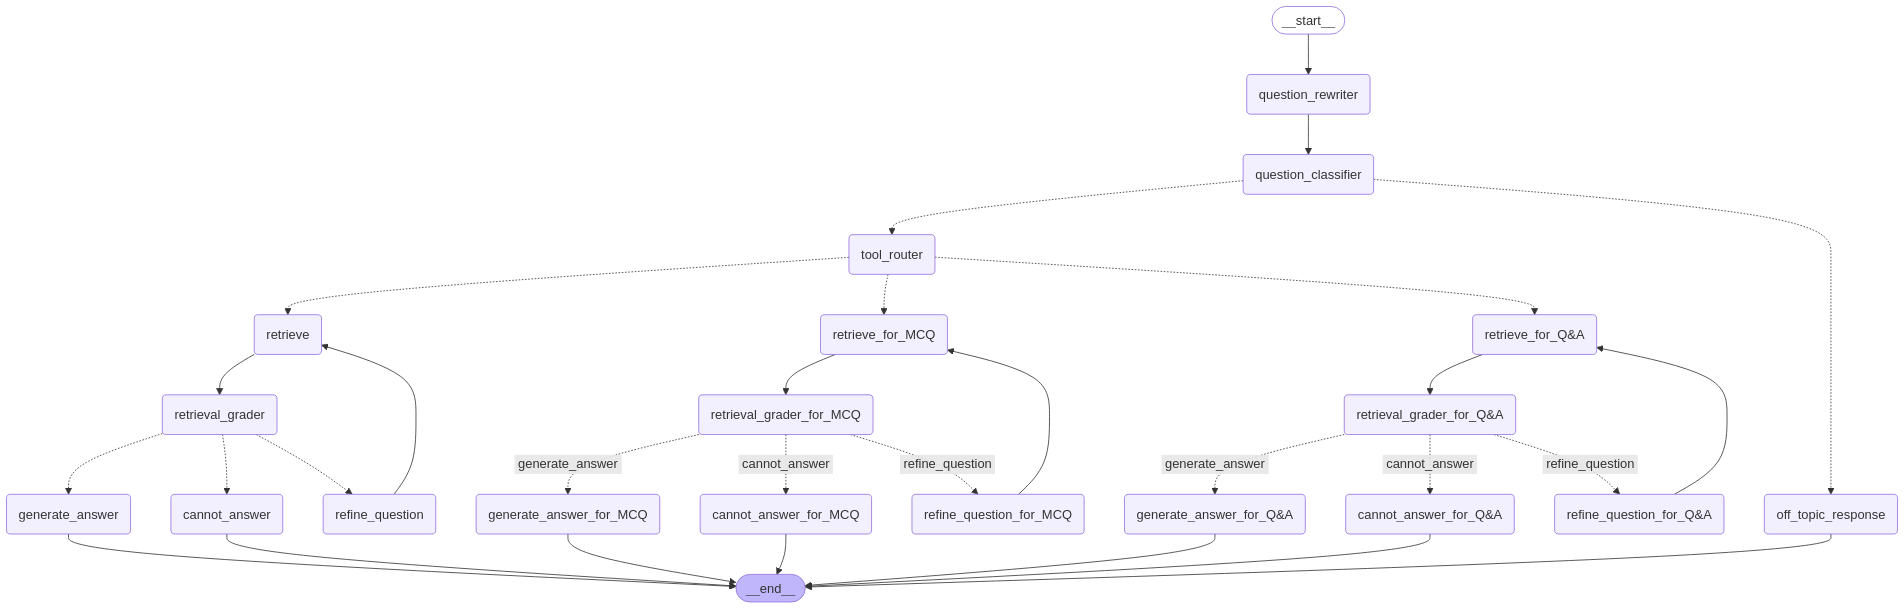

In [42]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Off topic request

In [15]:
off_topic_content_rag = "How is the weather?"
input_data = {"question": HumanMessage(content=off_topic_content_rag)}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'question': HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response


{'messages': [HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I can't respond to that!", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'How is the weather?',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={})}

### No relevant docs found

In [16]:
no_docs_cotent_rag = "In the feald of GNN, What is deepGCN?"
input_data = {"question": HumanMessage(content=no_docs_cotent_rag)}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})

Entering question_rewriter with following state: {'question': HumanMessage(content='In the feald of GNN, What is deepGCN?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 10 documents
Entering retrieval_grader
Grading document: ## DEEP CONVOLUTIONAL GAN (DCG... Result: No
Grading document: Big GAN... Result: No
Grading document: Ces GNN tombaient dans la caté... Result: No
Grading document: ## DCGAN... Result: No
Grading document: ## DCGAN... Result: No
Grading document: # DEEP LEARNING... Result: No
Grading document: Deep Graph Library... Result: No
Grading document: Nous couvrirons les encodeurs ... Result: No
Grading document: Les GNN sont réellement devenu... Result: No
Grading document: # GRAPH NEURAL NETWORKS... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_qu

{'messages': [HumanMessage(content='In the feald of GNN, What is deepGCN?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='DeepGCN is a type of Graph Neural Network (GNN) that focuses on the deep learning aspect of graph data. Specifically, it enhances the traditional GNN framework by incorporating deeper network architectures, allowing for improved feature extraction and representation learning from graphs. DeepGCN typically employs multiple layers of message passing, enabling the model to capture complex relationships and dependencies within the graph.\n\nDeepGCN is particularly useful in applications where the structure of the data is inherently graph-based, such as social networks, molecular structures, and recommendation systems. By leveraging the depth of the network, it aims to overcome some limitations of shallow GNNs, such as over-smoothing, where node representations become indistinguishable after several layers of aggregation.\n\nIn summary, DeepGCN repres

### RAG with memory in acction

In [17]:
memory_content_1_rag = "What is a graph neural network? enter in details"
input_data = {"question": HumanMessage(content=memory_content_1_rag)}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'question': HumanMessage(content='What is a graph neural network? enter in details', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 10 documents
Entering retrieval_grader
Grading document: # GRAPH NEURAL NETWORKS... Result: Yes
Grading document: 1. Motivation 2. Types de grap... Result: Yes
Grading document: Deep Graph Library... Result: No
Grading document: La première application concrè... Result: No
Grading document: Scene Graphs... Result: No
Grading document: ## GRAPHES... Result: No
Grading document: Code Graphs... Result: No
Grading document: Knowledge Graphs... Result: No
Grading document: [L'image montre différents typ... Result: No
Grading document: Classification de graphes... Result: No
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer


{'messages': [HumanMessage(content='What is a graph neural network? enter in details', additional_kwargs={}, response_metadata={}),
  AIMessage(content="A graph neural network (GNN) is a type of neural network specifically designed to operate on graph data structures. In a graph, data is represented as nodes (or vertices) and edges (connections between nodes), making GNNs particularly powerful for tasks involving relational data.\n\n### Key Components of GNNs:\n\n1. **Node Embeddings**: GNNs learn embeddings for nodes, which are dense vector representations that capture information about the node's features and its neighborhood in the graph. These embeddings are crucial for tasks such as node classification or link prediction.\n\n2. **Message Passing**: GNNs utilize a message-passing mechanism, where nodes communicate with their neighbors to update their embeddings. This process allows nodes to aggregate information from their local graph structure and incorporate it into their represe

In [18]:
memory_content_2_rag = "Can you give me a use case of it?"
input_data = {"question": HumanMessage(content=memory_content_2_rag)}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='What is a graph neural network? enter in details', additional_kwargs={}, response_metadata={}), AIMessage(content="A graph neural network (GNN) is a type of neural network specifically designed to operate on graph data structures. In a graph, data is represented as nodes (or vertices) and edges (connections between nodes), making GNNs particularly powerful for tasks involving relational data.\n\n### Key Components of GNNs:\n\n1. **Node Embeddings**: GNNs learn embeddings for nodes, which are dense vector representations that capture information about the node's features and its neighborhood in the graph. These embeddings are crucial for tasks such as node classification or link prediction.\n\n2. **Message Passing**: GNNs utilize a message-passing mechanism, where nodes communicate with their neighbors to update their embeddings. This process allows nodes to aggregate information from their local graph 

{'messages': [HumanMessage(content='What is a graph neural network? enter in details', additional_kwargs={}, response_metadata={}),
  AIMessage(content="A graph neural network (GNN) is a type of neural network specifically designed to operate on graph data structures. In a graph, data is represented as nodes (or vertices) and edges (connections between nodes), making GNNs particularly powerful for tasks involving relational data.\n\n### Key Components of GNNs:\n\n1. **Node Embeddings**: GNNs learn embeddings for nodes, which are dense vector representations that capture information about the node's features and its neighborhood in the graph. These embeddings are crucial for tasks such as node classification or link prediction.\n\n2. **Message Passing**: GNNs utilize a message-passing mechanism, where nodes communicate with their neighbors to update their embeddings. This process allows nodes to aggregate information from their local graph structure and incorporate it into their represe

## MCQ Generator

#### Response.json

In [ ]:
quiz_dict = {
    "1": {
        "mcq": "multiple choice question",
        "options": {
            "a": "choice here",
            "b": "choice here",
            "c": "choice here",
            "d": "choice here"
        },
        "correct": "correct answer"
    },
    "2": {
        "mcq": "multiple choice question",
        "options": {
            "a": "choice here",
            "b": "choice herquiz_dicte",
            "c": "choice here",
            "d": "choice here"
        },
        "correct": "correct answer"
    },
    "3": {
        "mcq": "multiple choice question",
        "options": {
            "a": "choice here",
            "b": "choice here",
            "c": "choice here",
            "d": "choice here"
        },
        "correct": "correct answer"
    }
}

#### utils.py

In [ ]:
import os
import PyPDF2
import json
import traceback

# def read_file(file):
#     if file.name.endswith(".pdf"):
#         try:
#             pdf_reader=PyPDF2.PdfReader(file)
#             text=""
#             for page in pdf_reader.pages:
#                 text+=page.extract_text()
#             return text
            
#         except Exception as e:
#             raise Exception("error reading the PDF file")
        
#     elif file.name.endswith(".txt"):
#         return file.read().decode("utf-8")
    
#     else:
#         raise Exception(
#             "unsupported file format, only pdf and text file suppoted"
#             )

def get_table_data(quiz_str):
    try:
        # convert the quiz from a str to dict
        # print('\n'+quiz_str+'\n')
        # quiz_str = quiz_str.splitlines()
        # print('\n',quiz_str,'\n')  
        #       
        quiz_dict=json.loads(quiz_str)
        quiz_table_data=[]
        
        # iterate over the quiz dictionary and extract the required information
        for key,value in quiz_dict.items():
            mcq=value["mcq"]
            options=" || ".join(
                [
                    f"{option}-> {option_value}" for option, option_value in value["options"].items()
                 
                ]
            )
            
            correct=value["correct"]
            quiz_table_data.append({"MCQ": mcq,"Choices": options, "Correct": correct})
        
        return quiz_table_data
        
    except Exception as e:
        traceback.print_exception(type(e), e, e.__traceback__)
        return False

ModuleNotFoundError: No module named 'PyPDF2'

#### MCQGenerator.py

In [ ]:
import os
import json
import traceback
import pandas as pd 
from dotenv import load_dotenv
from src.mcqgenerator.utils import read_file, get_table_data
from src.mcqgenerator.logger import logging

# importing necessary packages from langchain
# from langchain.chat_models import ChatOpenAI
# from langchain_community.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain, SequentialChain
from langchain_community.llms import HuggingFaceHub

# Load environment variables from .env file
load_dotenv()

# Access environment variables with os.getenv()
openai_key = os.getenv("OPENAI_API_KEY")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACE_API_KEY")

model1= "gpt-3.5-turbo"
model2= "gpt-4o"
model3 = "mistralai/Mistral-7B-Instruct-v0.3"
model4 = "meta-llama/Meta-Llama-3-8B-Instruct"
model5 = "meta-llama/Meta-Llama-3-8B"

llm1 = ChatOpenAI(openai_api_key=openai_key, model_name=model1, temperature=0.7)
llm2 = ChatOpenAI(openai_api_key=openai_key, model_name=model2, temperature=0.7)
llm3 = HuggingFaceHub(repo_id=model3, model_kwargs={'temperature':1,'max_new_tokens': 1000})
llm4 = HuggingFaceHub(repo_id=model4, model_kwargs={'temperature':1})

quiz_generator_template = '''
Text:{text}
You are an expert MCQ maker. Given the above text, your job is to create a quiz of {number} multiple choice questions for {subject} students in {tone} tone. 
Make sure the questions are not repeated and check all the questions to be conformed to the text. Ensure to make {number} MCQs.
Make sure to format your response like RESPONSE_JSON below and use it as a guide. 
###RESPONSE_JSON:
{response_json}

'''

quiz_generator_prompt = PromptTemplate(
    input_variables=["text", "number", "subject", "tone", "response_json"],
    template = quiz_generator_template
)

quiz_chain = LLMChain(llm=llm1, prompt=quiz_generator_prompt, output_key="quiz", verbose=True)

quiz_evaluation_template="""
You are an expert english grammarian and writer. Given a Multiple Choice Quiz for {subject} students.\
You need to evaluate the complexity of the question and give a complete analysis of the quiz. Only use at max 50 words for complexity analysis. 
if the quiz is not at per with the cognitive and analytical abilities of the students,\
update the quiz questions which needs to be changed and change the tone such that it perfectly fits the student abilities
Quiz_MCQs:
{quiz}

Check from an expert French Writer of the above quiz:
"""

quiz_evaluation_prompt = PromptTemplate(input_variables=["subject", "quiz"], template=quiz_evaluation_template)

review_chain=LLMChain(llm=llm1, prompt=quiz_evaluation_prompt, output_key="review", verbose=True)


# Overall chain allowing to run the two chains in sequence
generate_evaluate_chain = SequentialChain(chains=[quiz_chain, review_chain], input_variables=["text", "number", "subject", "tone", "response_json"], output_variables=["quiz", "review"], verbose=True)

